# Tutorial: How to describe a set of images in terms of visual clusters

This is a tutorial on how to process a set of images with a pretrained computer vision model to obtain latent representations, cluster them with K-means, and calculate how many photos belong to each category. This example was adapted by the following [example](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34) from Gabe Flomo. If you are having problems with the tutorial, or have any questions contact me at sebtop@kt.dtu.dk, [@littlecodelover](https://twitter.com/littlecodelover) or [LinkedIn](https://www.linkedin.com/in/sebastian-topalian-3b1743204/).





Here we use images related to the following publication(s):
- ECO-STP Conference: Quantitative Image Analysis of Biosolids: Evaluating morphological parameters versus visual features # Insert DOI here

- Full journal paper: Title # Insert DOI here

## 1. Open the notebook in Colab and change runtime type

To run the code and experiment click the badge below if you don't have the notebook opened in colab already.

<a target="_blank" href="https://colab.research.google.com/github/waterboy96/ImageAnalysis/blob/main/Quantitative_Image_Analysis_of_Biosolids_Evaluating_morphological_parameters_versus_visual_features.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Before running the code you should change the runtime to a runtime type with a GPU. This helps us speed up the inference from the image model used later on. In the menu above select runtime, change runtime type and then from the hardware accelerator drop down menu select GPU.

## 2. Download zip file and unzip

First we download pictures from a sample of inactivated biomass. These photos were taken and segmented with an Ocelloscope and accompanying software from [ParticleTech](https://particletech.dk).

In [1]:
!git clone https://github.com/waterboy96/ImageAnalysis.git

Cloning into 'ImageAnalysis'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 5.93 MiB | 6.32 MiB/s, done.


In [2]:
!unzip -q ImageAnalysis/Particles.zip

## 3. Import necessary packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.applications import Xception
from keras.models import Model
from keras.utils import image_dataset_from_directory, load_img


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## 4. Load Xception model and generate feature vectors

In [4]:
model = Xception()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

91884032/91884032 [==============================] - 3s 0us/step


In [5]:
ds = image_dataset_from_directory('Particles', batch_size= 64, image_size = (299,299), labels = None, shuffle = False, label_mode= None)
df = pd.DataFrame(model.predict(ds))

Found 1569 files belonging to 1 classes.
25/25 [==============================] - 21s 464ms/step


In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,54.397377,31.481085,0.0,0.0,4.651551,5.417994,0.0,54.248188,0.0,...,0.0,0.547659,0.584891,0.0,0.0,0.0,0.0,0.0,28.481733,0.0
1,0.0,9.573967,68.260956,0.0,0.0,9.481168,2.677141,0.0,62.059071,0.0,...,0.0,0.000000,9.717825,0.0,0.0,0.0,0.0,0.0,32.673744,0.0
2,0.0,73.179329,54.697803,0.0,0.0,2.832877,1.836954,0.0,95.356827,0.0,...,0.0,0.000000,6.211997,0.0,0.0,0.0,0.0,0.0,36.757622,0.0
3,0.0,9.200871,47.524445,0.0,0.0,2.823270,1.756664,0.0,111.240677,0.0,...,0.0,0.083808,0.606889,0.0,0.0,0.0,0.0,0.0,49.801151,0.0
4,0.0,9.845015,14.987322,0.0,0.0,1.928177,3.383067,0.0,3.051227,0.0,...,0.0,0.094376,0.000000,0.0,0.0,0.0,0.0,0.0,18.205931,0.0


We now have a vector of length 2048 for each picture in our sample. These vectors represent the output of the penultimate layer in the Xception model which can be used to describe our images.

## 5. Reduce dimensionality with PCA

In [7]:
df_scaled = (df-df.mean())/df.std()
df_scaled.dropna(axis = 1, inplace = True)

In [8]:
pca = PCA()
pca.fit(df_scaled)

PCA()

We pick a threshold of how much of the variance that should be retained. Here we select 99%. Reducing the dimensionality of the vectors helps with the computational time of clustering in the next step.

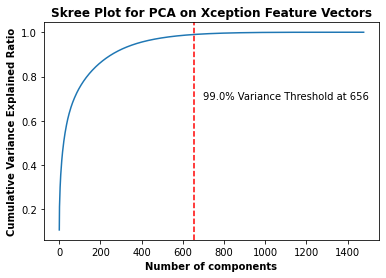

In [9]:
variance_threshold = 0.99

plt.plot([x for x in range(len(pca.explained_variance_))], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components', fontweight = 'bold')
plt.ylabel('Cumulative Variance Explained Ratio', fontweight = 'bold')
ax = plt.gca()
plt.title('Skree Plot for PCA on Xception Feature Vectors', fontweight = 'bold')
plt.axvline(np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold), linestyle = '--', c = 'red')
plt.text(700,0.7,f'{variance_threshold*100}% Variance Threshold at {np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold)}')
plt.show()

An argument could be made to reduce the threshold to the point where the curve evens out for further reduction.

In [10]:
threshold = np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold)

In [11]:
pca_threshold = PCA(n_components=threshold)

In [12]:
PCs = pca_threshold.fit_transform(df_scaled)

## 6. K-means clustering and cluster counting

In [13]:
KM = KMeans(n_clusters = 6)

In [14]:
KM.fit(PCs)

KMeans(n_clusters=6)

In [15]:
labels = labels = KM.predict(PCs)

In [16]:
def Count_values(X,Clusters):
    return pd.DataFrame([(len(X[X == i])/len(X)) for i in range(Clusters)]).T

In [17]:
Count_values(labels,6)

,0,1,2,3,4,5
0,0.223072,0.407903,0.185468,0.000637,0.158062,0.024857


We can see that the distribution between the different clusters for this sample is quite uneven.

This vector is what we in the beforementioned literature reffered to as cluster participation vectors which showed better performance for predicitng reject turbidity than both clusters built on conventional morphological parameters such as length, area etc. and also better performance than the mean of said morphological parameters.

## 7. Visualisation of clusters

In [18]:
particles = []

with os.scandir('Particles')as files:
    for file in files:
        if file.name.endswith('.png'):
            particles.append(file.name)

In [19]:
particles = sorted(['Particles/'+p for p in particles if not p.startswith('.')])

In [20]:
groups = {}

for file, cluster in zip(particles, labels):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [21]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the lits of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
        
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10, index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 640 to 30


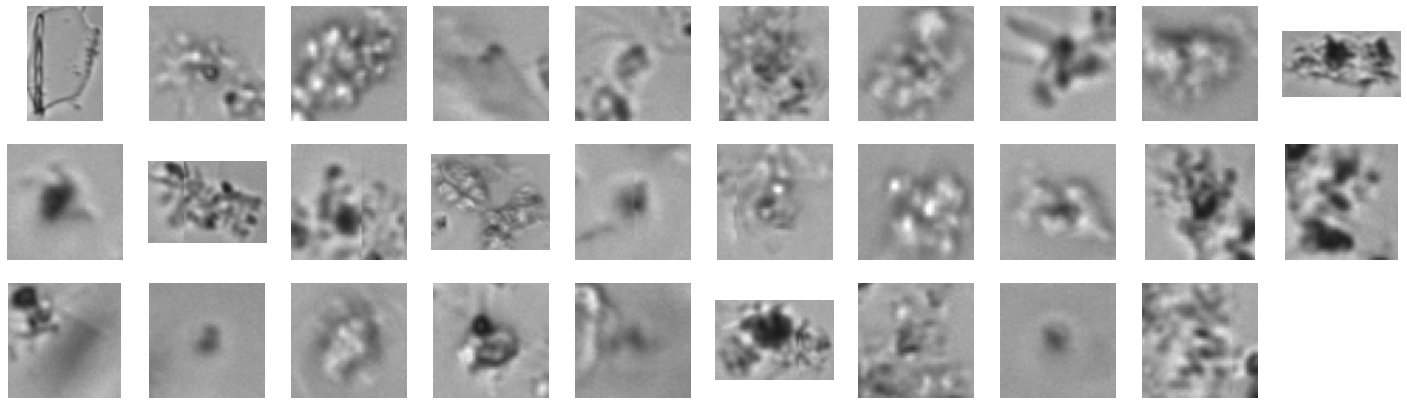

In [22]:
view_cluster(1) 

Try changing the above number to visualise a different cluster. (Don't forget cluster 0)

# Conclusion

That is it for this tutorial. If you have a particularly large number of photos I would suggest considering down sampling as K-means scales poorly. For questions contact me at sebtop@kt.dtu.dk, [@littlecodelover](https://twitter.com/littlecodelover) or [LinkedIn](https://www.linkedin.com/in/sebastian-topalian-3b1743204/).

